##Load Lenta dataset

In [ ]:
import sys
# install uplift library scikit-uplift and other libraries
!{sys.executable} -m pip install scikit-uplift catboost scikit-learn seaborn matplotlib pandas numpy
from sklift.datasets import fetch_lenta
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 635.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.1 MB/s eta 0:00:00


In [ ]:
dataset = fetch_lenta()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")
dataset.keys()

Lenta dataset:   0%|          | 0.00/145M [00:00<?, ?iB/s]

Dataset type: <class 'sklearn.utils._bunch.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [ ]:
dataset.data

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_g27,sale_sum_12m_

Dataset is a dictionary-like object with the following attributes:
* ``data`` (DataFrame object): Dataset without target and treatment.
* ``target`` (Series object): Column target by values.
* ``treatment`` (Series object): Column treatment by values.
* ``DESCR`` (str): Description of the Lenta dataset.
* ``feature_names`` (list): Names of the features.
* ``target_name`` (str): Name of the target.
* ``treatment_name`` (str): Name of the treatment.
                
**Major columns:**
- treatment `group` (str): test/control group flag
- target `response_att` (binary): target
- data `gender` (str): customer gender
- data `age` (float): customer age
- data `main_format` (int): store type (1 - grociery store, 0 - superstore)

Detailed feature description could be found [here](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta).

In [ ]:
# Weight of Evidence
import math
good = dataset.target.sum()
bad = (dataset.target.shape[0] - dataset.target.sum())
WOE = math.log(good / bad)
print("WOE:", WOE, "Good:", good, "Bad:", bad);

# Information Value of treatment
n = dataset.target.shape[0]
good_sum = dataset.target[(dataset.treatment == 1) & (dataset.target == 1)].shape[0]
bad_sum = dataset.target[(dataset.treatment == 1) & (dataset.target == 0)].shape[0]
print("N:", n, "Good Distribution:", good_sum, "Bad Distribution:", bad_sum);
IV = (good_sum/n - bad_sum/n) * WOE
print("IV:", IV)

In [ ]:
# Proportions
import numpy as np
import matplotlib.pyplot as plt

columns = ["cheque_count_3m_g20", "cheque_count_6m_g20", "cheque_count_12m_g20"]
treated = []
controlled = []
for column in columns:
  treated.append(
      dataset.data[dataset.treatment == 1][column].sum()
  )
  controlled.append(
      dataset.data[dataset.treatment == 0][column].sum()
  )

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.bar(br1, controlled, color ='grey', width = barWidth,
        edgecolor ='grey', label ='control group')
plt.bar(br2, treated, color ='blue', width = barWidth,
        edgecolor ='cyan', label ='treatement group')

plt.xlabel('g20', fontweight ='bold', fontsize = 15)
plt.ylabel('Total cheque', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['3m', '6m', '12m'])
plt.legend()
plt.show()


In [ ]:
# Proportions of Crazye
import numpy as np
import matplotlib.pyplot as plt

columns = ["crazy_purchases_cheque_count_3m", "crazy_purchases_cheque_count_6m", "crazy_purchases_cheque_count_12m"]
treated = []
controlled = []
for column in columns:
  treated.append(
      dataset.data[dataset.treatment == 1][column].sum()
  )
  controlled.append(
      dataset.data[dataset.treatment == 0][column].sum()
  )

barWidth = 0.25
fig = plt.subplots(figsize =(10, 8))
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.bar(br1, controlled, color ='grey', width = barWidth,
        edgecolor ='grey', label ='control group')
plt.bar(br2, treated, color ='blue', width = barWidth,
        edgecolor ='cyan', label ='treatement group')

plt.xlabel('Crazy Purchases', fontweight ='bold', fontsize = 15)
plt.ylabel('Total cheque', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['3m', '6m', '12m'])
plt.legend()
plt.show()

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', None)
dataset.data.isnull().sum()

age                                     11765
cheque_count_12m_g20                        0
cheque_count_12m_g21                        0
cheque_count_12m_g25                        0
cheque_count_12m_g32                        0
cheque_count_12m_g33                        0
cheque_count_12m_g38                        0
cheque_count_12m_g39                        0
cheque_count_12m_g41                        0
cheque_count_12m_g42                        0
cheque_count_12m_g45                        0
cheque_count_12m_g46                        0
cheque_count_12m_g48                        0
cheque_count_12m_g52                        0
cheque_count_12m_g56                        0
cheque_count_12m_g57                        0
cheque_count_12m_g58                        0
cheque_count_12m_g79                        0
cheque_count_3m_g20                     94064
cheque_count_3m_g21                     94064
cheque_count_3m_g25                     94064
cheque_count_3m_g42               

## Target share for treatment / control

<Axes: xlabel='response_att', ylabel='count'>

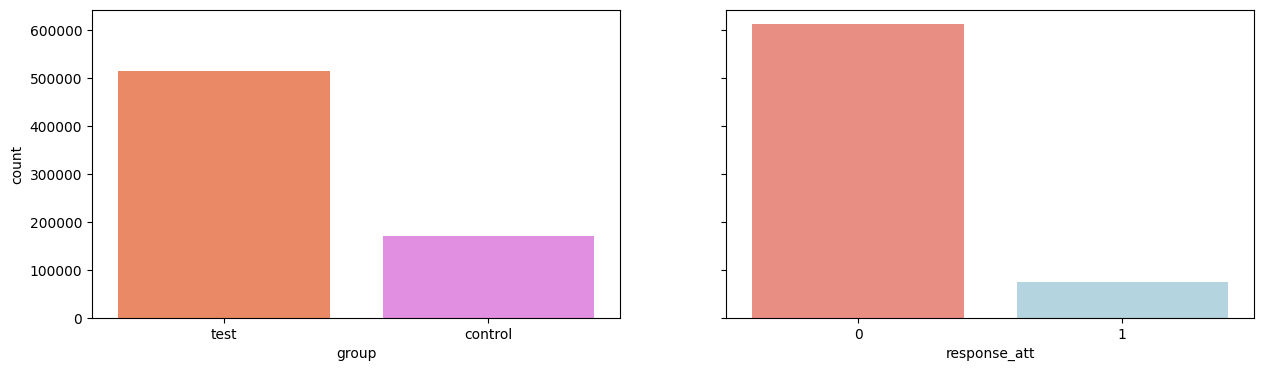

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))

treatment = dataset["treatment"]
target = dataset["target"]

palette_colors = {"test": "coral", "control": "violet", "0": "salmon", "1": "lightblue"}

sns.countplot(x=treatment, ax=ax[0],  palette=palette_colors)
sns.countplot(x=target, ax=ax[1], palette=palette_colors)

In [ ]:
def crosstab_plot(treatment, target):
    ct = pd.crosstab(treatment, target, normalize='index')

    sns.heatmap(ct, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Purples_r')
    plt.ylabel('Treatment')
    plt.xlabel('Target')
    plt.title("Treatment - Target", size = 15)

crosstab_plot(dataset.treatment, dataset.target)

<Axes: >

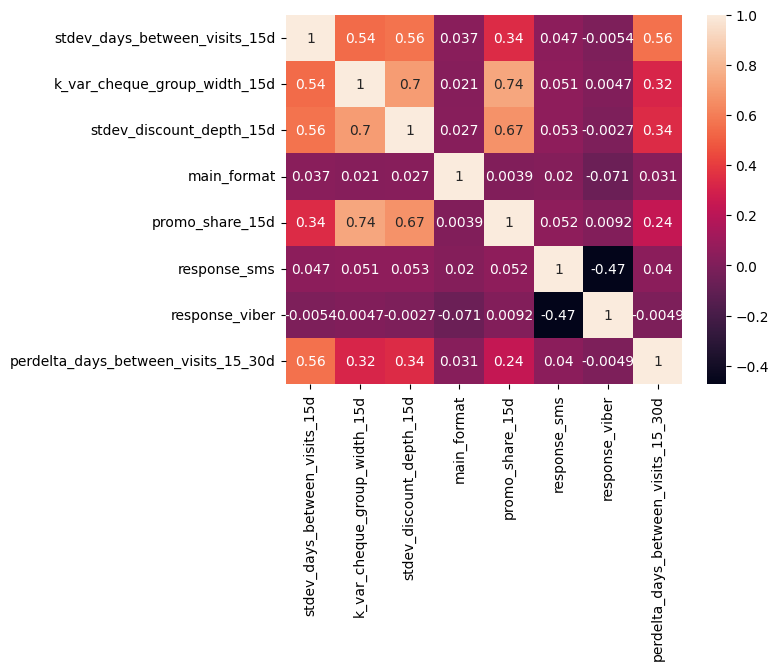

In [ ]:
treat_dict = {
    'test': 1,
    'control': 0
}
dataset.treatment = dataset.treatment.map(treat_dict)

# make gender binary
gender_dict = {
    'M': 1,
    'Ж': 0
}
dataset.data.gender = dataset.data.gender.map(gender_dict)
dataset.data.gender = dataset.data.gender.map(gender_dict)
sns.heatmap(dataset.data[[ "stdev_days_between_visits_15d", "k_var_cheque_group_width_15d", "stdev_discount_depth_15d", "main_format", "promo_share_15d","response_sms", "response_viber", "perdelta_days_between_visits_15_30d" ]].corr(), annot = True)

In [ ]:
dataset.data[dataset["treatment"] == 'test']

In [ ]:
Treated = dataset.data[dataset["treatment"] == 'test']
Controlled = dataset.data[dataset["treatment"] == 'control']

In [ ]:
Data = dataset.data.fillna(0.0)
Target = dataset.target.fillna(0.0)
print(Target.isna().sum())

0


In [ ]:
# ==== Response Model ====

# == Data ==
length = dataset.data.shape[0]
train_length = math.floor(length / 2)
Data = dataset.data.fillna(0.0)
Target = dataset.target.fillna(0.0)

X_Train = Data[:train_length]
X_Test = Data[train_length:]
Y_Train = Target[:train_length]
Y_Test = Target[train_length:]

# == Accuracy ==
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error


def normalize(value):
  return np.round(abs(value))


def response_accuracy(m, x, y):
  y_pred = normalize(m.predict(x))
  print("Accuracy:", accuracy_score(y, y_pred))
  print("F1:", f1_score(y, y_pred, average='weighted'))
  if(hasattr(m, "decision_function")):
    print("ROC AUC:", roc_auc_score(y, m.decision_function(x)))
  print("MSE:", mean_squared_error(y, y_pred))

In [ ]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=0)
model.fit(X_Train, Y_Train)
response_accuracy(model, X_Test, Y_Test)

Accuracy: 0.891789295955053
F1: 0.8437759358194022
MSE: 0.10934893672765382


In [ ]:
# Stochastic Gradient Descent Classifier
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter=1000, tol=1e-3)
model.fit(X_Train, Y_Train)
response_accuracy(model, X_Test, Y_Test)

Accuracy: 0.8888549262768729
F1: 0.8434717375258635
ROC AUC: 0.3641378479513654
MSE: 0.11114507372312708


In [ ]:
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier as GBC

model = GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_Train, Y_Train)
response_accuracy(model, X_Test, Y_Test)

Accuracy: 0.8963596931720594
F1: 0.8658924815584299
ROC AUC: 0.788487844065876
MSE: 0.10364030682794055


In [ ]:
# Response with Treatment

# Data
length = dataset.data.shape[0]
train_length = math.floor(length / 2)
Data = dataset.data.fillna(0.0)
Target = dataset.target.fillna(0.0)
Treatment = dataset.treatment.fillna(1)
Data["treatment"] = Treatment

X_Train = Data[:train_length]
X_Test = Data[train_length:]
Y_Train = Target[:train_length]
Y_Test = Target[train_length:]

# Model
from sklearn.ensemble import GradientBoostingClassifier as GBC

model = GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
model.fit(X_Train, Y_Train)
print("Score:", model.score(X_Test, Y_Test))

Score: 0.8964441145219277


In [ ]:
# Importance of Treatment
print(model.feature_importances_[len(model.feature_importances_)-1])

0.0002559464475699562


In [ ]:
# Simple Uplift Model

from sklift.models import SoloModel, ClassTransformation, TwoModels
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC



#ClassTransformation(SGDClassifier(loss="log_loss", random_state=0)) 0.008
#ClassTransformation(CatBoostClassifier(random_state=0)) 0.046
#ClassTransformation(GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)) 0.047
# slearner = TwoModels(
#     estimator_trmnt=CatBoostClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
#     estimator_ctrl=CatBoostClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
#     method='ddr_control') 0.0112
# slearner = TwoModels(
#     estimator_trmnt=RFC(random_state=0),
#     estimator_ctrl=RFC(random_state=0),
#     method='ddr_control')  0.008809529682250683

estimator = LGBMClassifier(n_estimators=10)
slearner = TwoModels(
    estimator_trmnt=RFC(random_state=0),
    estimator_ctrl=RFC(random_state=0),
    method='ddr_control')

# Data
length = dataset.data.shape[0]
train_length = math.floor(length / 2)
Data = dataset.data.fillna(0.0)
Target = dataset.target.fillna(0.0)
Treatment = dataset.treatment.fillna(1)

X_Train = Data[:train_length]
X_Test = Data[train_length:]
Y_Train = Target[:train_length]
Y_Test = Target[train_length:]
T_Train = Treatment[:train_length]
T_Test = Treatment[train_length:]

# List
soloModels = [
    ["Solo: GradientBoost", SoloModel(GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))],
    ["Solo: CatBoost", SoloModel(CatBoostClassifier(random_state=0))],
]
twoModels = [
    ["Two: CatBoost", TwoModels(
      estimator_trmnt=CatBoostClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
      estimator_ctrl=CatBoostClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
      method='ddr_control')],
    ["Two: RandomForest", TwoModels(
      estimator_trmnt=RFC(random_state=0),
      estimator_ctrl=RFC(random_state=0),
      method='ddr_control')]
]
transformModels = [
    ["Class: GradientBoost", ClassTransformation(GBC(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))],
    ["Class: CatBoost", ClassTransformation(CatBoostClassifier(random_state=0))],
    ["Class: SGD", ClassTransformation(SGDClassifier(loss="log_loss", random_state=0))]
]

In [ ]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import plot_qini_curve
import matplotlib.pyplot as plt


def try_model(name, slearner):
  print("==========", name, "==========")
  slearner.fit(
    X=X_Train,
    y=Y_Train,
    treatment=T_Train,
  )
  uplift_slearner = slearner.predict(X_Test)
  uplift_at_k1 = uplift_at_k(y_true=Y_Test, uplift=uplift_slearner,
                            treatment=T_Test,
                            strategy='overall', k=0.3)
  qini_coef = qini_auc_score(y_true=Y_Test, uplift=uplift_slearner,
                            treatment=T_Test)
  uplift_auc = uplift_auc_score(y_true=Y_Test, uplift=uplift_slearner,
                                treatment=T_Test)
  wau = weighted_average_uplift(y_true=Y_Test, uplift=uplift_slearner,
                                treatment=T_Test)
  print("uplift_at_k", uplift_at_k1)
  print("qini_coef", qini_coef)
  print("uplift_auc", uplift_auc)
  print("wau", wau)
  fig, ax = plt.subplots(1, 1)
  ax.set_title('Qini curves')
  plot_qini_curve(
      Y_Test, uplift_slearner, T_Test,
      perfect=True, name='Slearner', ax=ax
  );
  print("========== End ==========")


In [ ]:
for inst in soloModels:
  try_model(inst[0], inst[1])

for inst in twoModels:
  try_model(inst[0], inst[1])

for inst in transformModels:
  try_model(inst[0], inst[1])

In [ ]:
# Evaluation
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

uplift_slearner = slearner.predict(X_Test)

# Uplift@30%
uplift_at_k = uplift_at_k(y_true=Y_Test, uplift=uplift_slearner,
                          treatment=T_Test,
                          strategy='overall', k=0.3)

# Area Under Qini Curve
qini_coef = qini_auc_score(y_true=Y_Test, uplift=uplift_slearner,
                           treatment=T_Test)

# Area Under Uplift Curve
uplift_auc = uplift_auc_score(y_true=Y_Test, uplift=uplift_slearner,
                              treatment=T_Test)

# Weighted average uplift
wau = weighted_average_uplift(y_true=Y_Test, uplift=uplift_slearner,
                              treatment=T_Test)
print("uplift_at_k", uplift_at_k) # 0.7-1.0
print("qini_coef", qini_coef) # ~1
print("uplift_auc", uplift_auc) # 0.8-0.9
print("wau", wau)